# Recursive Centrality Metrics on the Zachary Karate Club Network

This notebook reviews **recursive** centrality measures on the classic **Zachary Karate Club** social network.

A key motivation is that many **structural** metrics --- such as **degree** (local connectivity) and metrics based on **shortest paths** (e.g., closeness and betweenness) --- are typically **not robust to small graph perturbations**. A few strategically placed edge additions/removals can noticeably change shortest-path structure and therefore shift rankings. In contrast, **recursive** metrics (e.g., eigenvector, Katz, PageRank) aggregate information more globally through **feedback/propagation mechanisms**. As a result, they are often **more robust to small perturbations** and generally **less prone to manipulation by individual nodes** (for example, by attaching many low-quality neighbors).

In [1]:
## Reproducibility: We fix a random seed and reuse a single layout so plots are consistent.

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

SEED = 8
np.random.seed(SEED)

plt.rcParams["figure.figsize"] = (7, 6)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10


## 1. Load the Zachary Karate Club network

The Zachary graph has 34 nodes and 78 edges. Nodes represent members; edges represent social ties observed by Zachary.

We treat the graph as **undirected and unweighted**.


Zachary Karate Club graph: n=34, m=78, directed=False
Connected? True


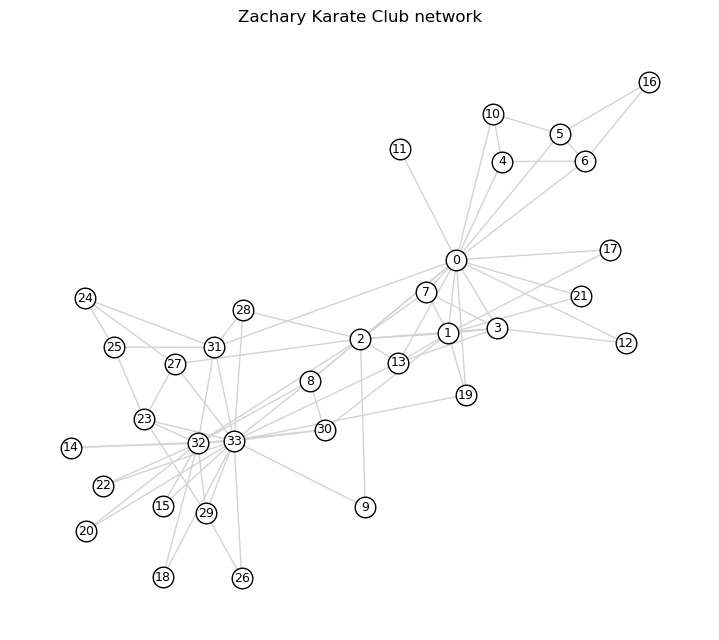

In [2]:
G = nx.karate_club_graph()
print(f"Zachary Karate Club graph: n={G.number_of_nodes()}, m={G.number_of_edges()}, directed={G.is_directed()}")
print("Connected?", nx.is_connected(G))

# Re-use a consistent layout for all plots
pos = nx.spring_layout(G, seed=SEED)

# Show the network using the spring layout
plt.figure(figsize=(7, 6))
nx.draw(G, pos=pos, node_size=220, edge_color="lightgray", node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos=pos, font_size=9)
plt.title("Zachary Karate Club network")
plt.axis("off")
plt.show()

## 2. Helper functions

In this section, we define a small collection of **utility functions** that will help us:

- compute and organize centrality measures,
- assemble comparison tables across multiple metrics,
- extract top-ranked nodes,
- and visualize the network with nodes colored according to a given score.

These helper functions are not specific to the Zachary network — they can be reused for any graph.

In [3]:
def centrality_table(cent_dicts: dict) -> pd.DataFrame:
    """
    Build a comparison table from a dictionary of centrality measures.

    Parameters
    ----------
    cent_dicts : dict
        Mapping metric_name -> {node: score}

    Returns
    -------
    pd.DataFrame
        DataFrame with:
        - one row per node,
        - one column per centrality score,
        - additional columns with ranks (1 = highest score).
    """
    # Extract node set from first metric and sort them
    nodes = sorted(next(iter(cent_dicts.values())).keys())

    # Initialize DataFrame indexed by nodes
    df = pd.DataFrame(index=nodes)

    # Add one column per centrality measure
    for name, d in cent_dicts.items():
        df[name] = pd.Series(d)

    # Compute ranks for each metric (higher score = better rank)
    for name in cent_dicts.keys():
        df[name + "_rank"] = df[name].rank(
            ascending=False,  # higher scores get smaller rank numbers
            method="min"      # ties get the same minimum rank
        ).astype(int)

    return df


def topk(df: pd.DataFrame, metric: str, k: int = 10) -> pd.DataFrame:
    """
    Return the top-k nodes for a given metric.

    Parameters
    ----------
    df : pd.DataFrame
        Table produced by centrality_table.
    metric : str
        Name of the metric column.
    k : int
        Number of top nodes to return.

    Returns
    -------
    pd.DataFrame
        Top-k rows sorted by descending score.
    """
    # Keep only the score and rank columns for the selected metric
    cols = [metric, metric + "_rank"]

    # Sort by score (descending) and take first k rows
    return df.sort_values(metric, ascending=False)[cols].head(k)


def draw_by_score(G, pos, scores, title="", node_size=280, with_labels=True):
    """
    Visualize a graph with nodes colored according to a given score.

    Parameters
    ----------
    G : networkx.Graph
        Graph to draw.
    pos : dict
        Layout positions for nodes.
    scores : dict
        Mapping node -> score (e.g., centrality values).
    title : str
        Title of the plot.
    node_size : int
        Size of the nodes in the plot.
    with_labels : bool
        Whether to display node labels.
    """
    # Convert scores into an array aligned with node ordering
    vals = np.array([scores[v] for v in G.nodes()])

    # Create figure
    plt.figure(figsize=(7.2, 6.2))

    # Draw edges in light gray for context
    nx.draw_networkx_edges(G, pos=pos, edge_color="lightgray")

    # Draw nodes colored by score values
    nodes = nx.draw_networkx_nodes(
        G,
        pos=pos,
        node_color=vals,
        node_size=node_size,
        edgecolors="black",
        linewidths=0.8
    )

    # Optionally draw node labels
    if with_labels:
        nx.draw_networkx_labels(G, pos=pos, font_size=9)

    # Add title and colorbar
    plt.title(title)
    plt.axis("off")
    plt.colorbar(nodes, fraction=0.046, pad=0.04)

    # Show plot
    plt.show()

## 3. Structural centralities

In this section we compute three classic **structural** centrality measures. These metrics depend only on **local connectivity** (degree) or **shortest-path geometry** (closeness and betweenness).

### Metrics
- **Degree centrality:** counts how many neighbors a node has (local popularity).
- **Closeness centrality:** higher if a node is, on average, at small shortest-path distance from others (global reach).
- **Betweenness centrality:** higher if a node lies on many shortest paths between pairs (brokerage / bridging).

### Visualization convention (important)
To make the three plots directly comparable, we:
- **normalize each centrality vector to sum to 1**, and
- use **node color** and **node size** to represent the (normalized) centrality value.

This way, differences in size/color across panels reflect how each metric assigns importance.

,degree,closeness,betweenness,degree_rank,closeness_rank,betweenness_rank
0,0.484848,0.568966,0.437635,2,1,1
1,0.272727,0.485294,0.053937,5,9,7
2,0.303030,0.559322,0.143657,4,2,4
3,0.181818,0.464789,0.011909,6,10,15
4,0.090909,0.379310,0.000631,17,20,21


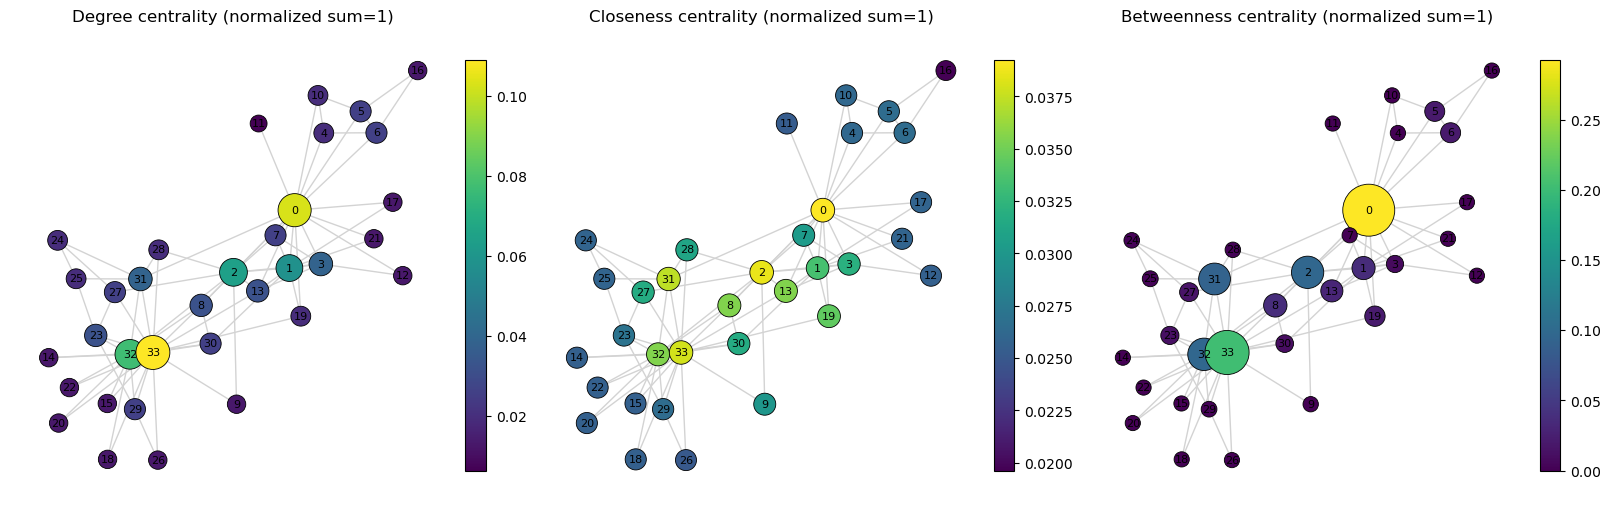

In [4]:
deg = nx.degree_centrality(G)
clo = nx.closeness_centrality(G)
bet = nx.betweenness_centrality(G, normalized=True)

cent_struct = {"degree": deg, "closeness": clo, "betweenness": bet}
df_struct = centrality_table(cent_struct)

display(df_struct.head())

# ----------------------------
# Side-by-side visualization (3 panels)
# - normalize each centrality to sum to 1
# - node color encodes normalized score
# - node size encodes normalized score (comparable across plots)
# ----------------------------
def normalize_sum1(scores: dict) -> dict:
    s = float(sum(scores.values()))
    return {k: (float(v) / s if s > 0 else 0.0) for k, v in scores.items()}


deg_n = normalize_sum1(deg)
clo_n = normalize_sum1(clo)
bet_n = normalize_sum1(bet)

# Common size scaling across panels (same min/max sizes)
# Size is proportional to normalized centrality, with a floor so small nodes remain visible.
all_vals = np.array(list(deg_n.values()) + list(clo_n.values()) + list(bet_n.values()))
vmin, vmax = float(all_vals.min()), float(all_vals.max())


def sizes_from_norm(scores_n: dict, smin=120, smax=1400):
    vals = np.array([scores_n[v] for v in G.nodes()])
    if vmax > vmin:
        vals01 = (vals - vmin) / (vmax - vmin)
    else:
        vals01 = np.zeros_like(vals)
    return smin + (smax - smin) * vals01


size_deg = sizes_from_norm(deg_n)
size_clo = sizes_from_norm(clo_n)
size_bet = sizes_from_norm(bet_n)

# Colors for each panel (arrays aligned with node order)
c_deg = np.array([deg_n[v] for v in G.nodes()])
c_clo = np.array([clo_n[v] for v in G.nodes()])
c_bet = np.array([bet_n[v] for v in G.nodes()])

fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

panels = [
    ("Degree centrality (normalized sum=1)", c_deg, size_deg),
    ("Closeness centrality (normalized sum=1)", c_clo, size_clo),
    ("Betweenness centrality (normalized sum=1)", c_bet, size_bet),
]

for ax, (title, colors, sizes) in zip(axes, panels):
    nx.draw_networkx_edges(G, pos=pos, edge_color="lightgray", ax=ax)
    nodes = nx.draw_networkx_nodes(
        G,
        pos=pos,
        node_color=colors,
        node_size=sizes,
        edgecolors="black",
        linewidths=0.6,
        ax=ax
    )
    nx.draw_networkx_labels(G, pos=pos, font_size=8, ax=ax)
    ax.set_title(title)
    ax.axis("off")
    fig.colorbar(nodes, ax=ax, fraction=0.046, pad=0.02)

plt.show()

## 4. Recursive centralities

In this section we compute three **recursive** notions of importance. Unlike purely structural metrics (degree/shortest paths), recursive centralities define importance **self-consistently**: a node is important if it is connected to other important nodes, possibly with additional modeling choices (baseline terms or random-walk normalization).

### Metrics
- **Eigenvector centrality:** importance comes from being connected to important neighbors (global feedback).
- **Katz centrality:** aggregates influence through **all walks**, discounting longer walks and adding a baseline so nodes avoid receiving zero score.
- **PageRank:** a random-walk-based score where importance is linked to how frequently a “random surfer” visits each node.

### Visualization convention (important)
To compare these three recursive metrics fairly, we:
- **normalize each centrality vector to sum to 1**, and
- use **node color** and **node size** to represent the (normalized) centrality value.

This makes node sizes directly comparable across panels.

lambda_max(A) ≈ 21.687566
Chosen Katz alpha = 0.039193 (must satisfy alpha < 1/lambda_max)
PageRank: sum(r_i) = 0.9999999999999999


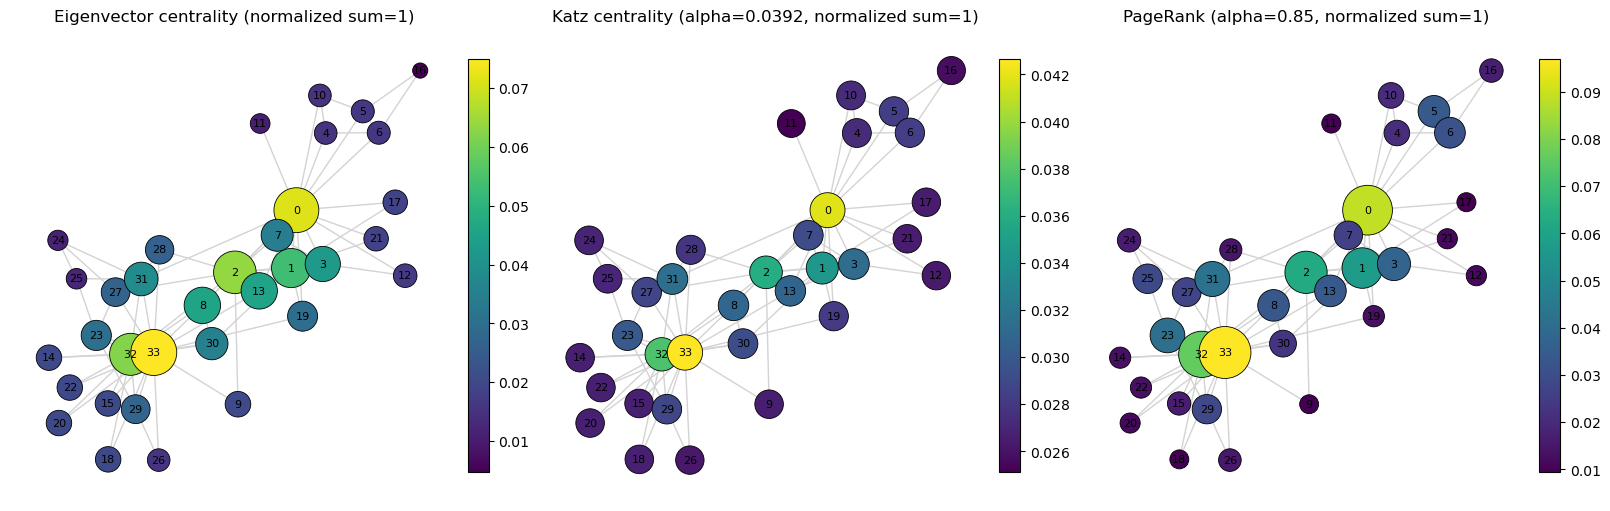

In [5]:
# Eigenvector centrality
eig = nx.eigenvector_centrality(G, max_iter=5000, tol=1e-10)

# Katz: choose alpha < 1/lambda_max
A = nx.to_numpy_array(G)
lambda_max = float(np.max(np.linalg.eigvalsh(A)))  # symmetric => real eigenvalues
alpha_katz = 0.85 / lambda_max
katz = nx.katz_centrality(
    G, alpha=alpha_katz, beta=1.0, max_iter=5000, tol=1e-10, normalized=True
)

# PageRank
pr = nx.pagerank(G, alpha=0.85, tol=1e-12)

cent_rec = {"eigenvector": eig, "katz": katz, "pagerank": pr}
df_rec = centrality_table(cent_rec)

print(f"lambda_max(A) ≈ {lambda_max:.6f}")
print(f"Chosen Katz alpha = {alpha_katz:.6f} (must satisfy alpha < 1/lambda_max)")
print("PageRank: sum(r_i) =", float(sum(pr.values())))


# ----------------------------
# Side-by-side visualization (3 panels)
# - normalize each centrality to sum to 1
# - node color encodes normalized score
# - node size encodes normalized score (comparable across plots)
# ----------------------------
def normalize_sum1(scores: dict) -> dict:
    s = float(sum(scores.values()))
    return {k: (float(v) / s if s > 0 else 0.0) for k, v in scores.items()}


eig_n = normalize_sum1(eig)
katz_n = normalize_sum1(katz)
pr_n = normalize_sum1(pr)

# Common size scaling across panels (same min/max sizes)
all_vals = np.array(list(eig_n.values()) + list(katz_n.values()) + list(pr_n.values()))
vmin, vmax = float(all_vals.min()), float(all_vals.max())


def sizes_from_norm(scores_n: dict, smin=120, smax=1400):
    vals = np.array([scores_n[v] for v in G.nodes()])
    if vmax > vmin:
        vals01 = (vals - vmin) / (vmax - vmin)
    else:
        vals01 = np.zeros_like(vals)
    return smin + (smax - smin) * vals01


size_eig = sizes_from_norm(eig_n)
size_katz = sizes_from_norm(katz_n)
size_pr = sizes_from_norm(pr_n)

# Colors for each panel (arrays aligned with node order)
c_eig = np.array([eig_n[v] for v in G.nodes()])
c_katz = np.array([katz_n[v] for v in G.nodes()])
c_pr = np.array([pr_n[v] for v in G.nodes()])

fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

panels = [
    ("Eigenvector centrality (normalized sum=1)", c_eig, size_eig),
    (f"Katz centrality (alpha={alpha_katz:.4f}, normalized sum=1)", c_katz, size_katz),
    ("PageRank (alpha=0.85, normalized sum=1)", c_pr, size_pr),
]

for ax, (title, colors, sizes) in zip(axes, panels):
    nx.draw_networkx_edges(G, pos=pos, edge_color="lightgray", ax=ax)
    nodes = nx.draw_networkx_nodes(
        G,
        pos=pos,
        node_color=colors,
        node_size=sizes,
        edgecolors="black",
        linewidths=0.6,
        ax=ax
    )
    nx.draw_networkx_labels(G, pos=pos, font_size=8, ax=ax)
    ax.set_title(title)
    ax.axis("off")
    fig.colorbar(nodes, ax=ax, fraction=0.046, pad=0.02)

plt.show()

## 5. Compare all metrics side-by-side

So far, we have computed several centrality measures — both **structural** and **recursive**.

In this section we:

1. Assemble a **single comparison table** containing all centrality scores and their rankings.
2. Compare the **rankings** rather than raw scores, defined as the **Pearson correlation of the rank vectors**:
$$
\rho_s(X,Y)
=
\mathrm{corr}\big(\operatorname{rank}_X,\operatorname{rank}_Y\big).
$$

### Why rank correlation?

- Different centralities live on different numerical scales.
- What often matters is not the raw value, but the **ordering of nodes**.
- Spearman correlation measures how similarly two metrics rank the nodes.
  - A value close to **1** means two metrics produce very similar rankings.
  - A value close to **0** means rankings are largely unrelated.
  - A negative value means opposite ordering.

This helps us understand:

- Which metrics behave similarly.
- Which ones capture fundamentally different notions of importance.

,degree_rank,closeness_rank,betweenness_rank,eigenvector_rank,katz_rank,pagerank_rank
degree_rank,1.000000,0.894507,0.904941,0.776562,0.978925,0.941868
closeness_rank,0.894507,1.000000,0.898015,0.856443,0.911623,0.737252
betweenness_rank,0.904941,0.898015,1.000000,0.693888,0.883287,0.841733
eigenvector_rank,0.776562,0.856443,0.693888,1.000000,0.844833,0.614067
katz_rank,0.978925,0.911623,0.883287,0.844833,1.000000,0.891407
pagerank_rank,0.941868,0.737252,0.841733,0.614067,0.891407,1.000000


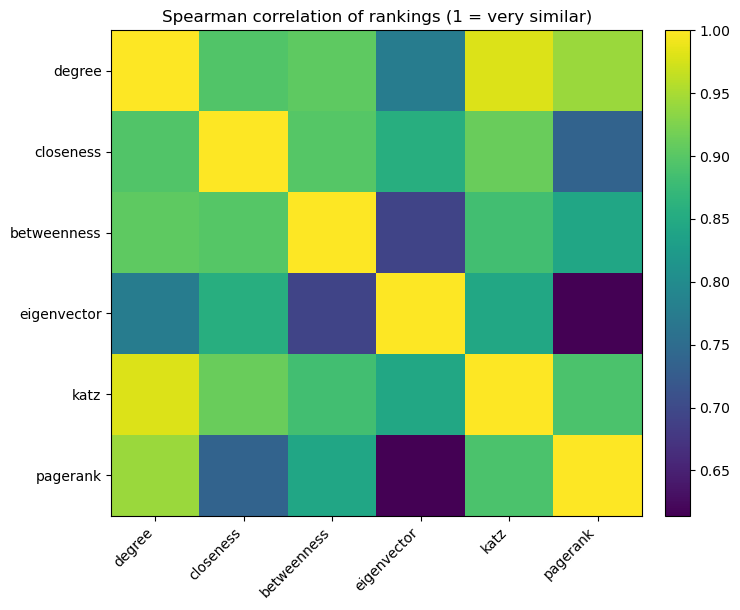

In [6]:
# ----------------------------
# Combine all centrality dictionaries
# ----------------------------
# cent_struct contains: degree, closeness, betweenness
# cent_rec contains: eigenvector, katz, pagerank
cent_all = {**cent_struct, **cent_rec}

# Build a unified comparison table:
# - one row per node
# - one column per centrality score
# - additional columns with ranks (1 = highest score)
df_all = centrality_table(cent_all)

# ----------------------------
# Compute Spearman rank correlations
# ----------------------------
# Extract the metric names
metrics = list(cent_all.keys())

# Build list of rank columns (e.g., degree_rank, closeness_rank, ...)
rank_cols = [m + "_rank" for m in metrics]

# Compute Spearman correlation matrix of rankings
# (Spearman measures correlation of orderings, not raw values)
spearman = df_all[rank_cols].corr(method="spearman")

display(spearman)

# ----------------------------
# Visualize correlation matrix as heatmap
# ----------------------------
plt.figure(figsize=(7.5, 6.2))

# Show correlation matrix
plt.imshow(spearman.values, aspect="auto")

# Label axes with metric names
plt.xticks(range(len(metrics)), metrics, rotation=45, ha="right")
plt.yticks(range(len(metrics)), metrics)

plt.title("Spearman correlation of rankings (1 = very similar)")
plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## 6. Small “manipulation” experiments (optional)

The purpose of this section is to use a few **controlled toy perturbations** to build intuition about how *sensitive* different centrality metrics are to small changes in the graph.

### What the code is doing

We pick a **target node** (in this case, node 10) and compare its **rank** under each centrality metric:

- **Before** any changes (baseline graph)
- **After** we modify the graph in a specific way

For each modified graph, we **recompute all centralities from scratch**, rebuild a table of scores/ranks, and then measure how much the target node’s **rank** changes.

### The three perturbations we test

1. **Attach many leaf nodes (“degree inflation”)**
   We connect many new nodes to the target node, each with degree 1.
   This usually increases **degree** a lot, but may have a smaller effect on recursive metrics.

2. **Add a shortcut edge (“closeness effect”)**
   We add one edge from the target to a far-away node (in hop distance).
   This tends to reduce average distances from the target, potentially boosting **closeness**.

3. **Add cross-community links (“betweenness effect”)**
   We connect the target to nodes from different groups, which can make it a bridge on many shortest paths.
   This can strongly affect **betweenness**.

### Important note about rankings

In our tables, **rank 1 means “highest centrality”** (best rank).
So if the rank number decreases, the node became *more central* according to that metric.

In [11]:
# ---------------------------------------------------------
# Helper functions for the “manipulation” experiments
# ---------------------------------------------------------

def add_leaf_friends(G, target, k, start_label=None):
    """
    Return a copy of G where we attach k NEW leaf nodes to 'target'.

    Each new node has degree 1 and connects only to the target:
        target -- new_node

    This is a simple way to inflate degree without adding real structure.
    """
    # Work on a copy so we do not modify the original graph
    H = G.copy()

    # Choose labels for new nodes that do not collide with existing ones
    if start_label is None:
        start_label = max(H.nodes()) + 1

    # Create k new node ids and add them to the graph
    new_nodes = list(range(start_label, start_label + k))
    H.add_nodes_from(new_nodes)

    # Connect each new node to the target node
    H.add_edges_from([(target, u) for u in new_nodes])

    return H


def recompute_all(H):
    """
    Recompute ALL centrality measures on graph H.

    Why do we recompute from scratch?
    Because each centrality is defined by the current graph structure.
    If the graph changes, all shortest paths / eigenvectors / walks may change too.
    """
    # Structural centralities
    deg = nx.degree_centrality(H)
    clo = nx.closeness_centrality(H)
    bet = nx.betweenness_centrality(H, normalized=True)

    # Eigenvector centrality (power iteration)
    eig = nx.eigenvector_centrality(H, max_iter=5000, tol=1e-10)

    # Katz centrality: choose alpha < 1/lambda_max for convergence
    A = nx.to_numpy_array(H)
    lambda_max = float(np.max(np.linalg.eigvalsh(A)))  # symmetric => real eigenvalues
    alpha_k = 0.85 / lambda_max

    katz = nx.katz_centrality(
        H,
        alpha=alpha_k,
        beta=1.0,
        max_iter=5000,
        tol=1e-10,
        normalized=True
    )

    # PageRank (random-walk-based)
    pr = nx.pagerank(H, alpha=0.85, tol=1e-12)

    # Return as a dictionary in the same format as earlier sections
    return {
        "degree": deg,
        "closeness": clo,
        "betweenness": bet,
        "eigenvector": eig,
        "katz": katz,
        "pagerank": pr
    }


def rank_of(df, metric, node):
    """
    Convenience function: return the rank of 'node' under a given metric.

    Recall:
    - rank 1 = highest centrality score
    - larger rank number = lower centrality
    """
    return int(df.loc[node, metric + "_rank"])


# ---------------------------------------------------------
# Baseline: show the target node's rank before any perturbations
# ---------------------------------------------------------

target = 10  # choose which node we are "testing"
print("Baseline ranks for node", target)

# We print the rank of the same node under multiple metrics
for metric in ["degree", "closeness", "betweenness", "eigenvector", "katz", "pagerank"]:
    print(f"{metric:12s}: rank = {rank_of(df_all, metric, target):2d}")

Baseline ranks for node 10
degree      : rank = 17
closeness   : rank = 20
betweenness : rank = 21
eigenvector : rank = 28
katz        : rank = 19
pagerank    : rank = 18


### 6.1 Leaf inflation (adds many low-quality neighbors)

In this experiment, we artificially increase the degree of the target node by
attaching several **new leaf nodes** (nodes of degree 1) to it.

These new nodes:

- connect only to the target,
- do not create new triangles,
- do not shorten paths between existing nodes,
- do not create new bridges between communities.

This mimics a scenario such as **buying fake followers**:
the node gains many connections, but those connections carry little structural value.

What should we expect?

- **Degree centrality** should increase dramatically.
- **Recursive metrics** (eigenvector centrality) may change less dramatically, since the new neighbors are themselves unimportant.

We now compare the target node's rank before and after the perturbation.

In [12]:
# ---------------------------------------------------------
# Leaf inflation experiment
# ---------------------------------------------------------

# Create a modified graph where the target node
# receives 10 new leaf neighbors (degree-1 nodes)
H1 = add_leaf_friends(G, target=target, k=10)

# Recompute all centralities on the modified graph
df_H1 = centrality_table(recompute_all(H1))

print(f"After attaching 10 leaf nodes to {target}:")

# Compare the target node's rank under each metric
# "before" refers to the original graph
# "after" refers to the modified graph H1
for metric in ["degree", "closeness", "betweenness",
               "eigenvector", "katz", "pagerank"]:
    before = rank_of(df_all, metric, target)
    after = rank_of(df_H1, metric, target)

    print(f"{metric:12s}: rank before = {before:2d}   rank after = {after:2d}")

After attaching 10 leaf nodes to 10:
degree      : rank before = 17   rank after =  3
closeness   : rank before = 20   rank after =  7
betweenness : rank before = 21   rank after =  2
eigenvector : rank before = 28   rank after = 23
katz        : rank before = 19   rank after =  4
pagerank    : rank before = 18   rank after =  1


### 6.2 Shortcut edge (reduces distances)

In this experiment, we add a **single shortcut edge** from the target node
to one of the nodes that is farthest away from it in terms of shortest-path distance.

Why do this?

- The new edge does **not** create many new neighbors (only one).
- But it can significantly reduce the **average distance** from the target to the rest of the graph.
- It may also alter shortest-path routing patterns.

What should we expect?

- **Degree centrality** increases only slightly (+1 edge).
- **Closeness centrality** should increase, since distances shrink.
- **Betweenness centrality** should also increase, since new shortest paths may be rerouted through the target.
- **Recursive metrics** may shift depending on how central the newly connected node is.

We now identify the farthest node (in hop distance) and connect it directly to the target.

In [13]:
# ---------------------------------------------------------
# Shortcut edge experiment
# ---------------------------------------------------------

# Compute shortest-path distances from the target node
dist_from_target = dict(nx.single_source_shortest_path_length(G, target))

# Identify the node farthest (in hop distance) from the target
far = max(dist_from_target, key=dist_from_target.get)

# Create a copy of the original graph
H2 = G.copy()

# Add a shortcut edge between target and the farthest node
H2.add_edge(target, far)

# Recompute centralities on the modified graph
df_H2 = centrality_table(recompute_all(H2))

print(f"Added shortcut edge ({target}, {far}),")
print(f"which was at distance {dist_from_target[far]} from the target in the original graph.\n")

# Compare the target node's rank before and after the perturbation
for metric in ["degree", "closeness", "betweenness",
               "eigenvector", "katz", "pagerank"]:
    before = rank_of(df_all, metric, target)
    after = rank_of(df_H2, metric, target)

    print(f"{metric:12s}: rank before = {before:2d}   rank after = {after:2d}")

Added shortcut edge (10, 23),
which was at distance 4 from the target in the original graph.

degree      : rank before = 17   rank after = 11
closeness   : rank before = 20   rank after = 13
betweenness : rank before = 21   rank after =  9
eigenvector : rank before = 28   rank after = 18
katz        : rank before = 19   rank after = 15
pagerank    : rank before = 18   rank after = 18


### 6.3 Cross-community links (affects brokerage)

In the Zachary network, the nodes are labeled according to the two factions/communities
that eventually split the club.

In this experiment, we:

- use these labels as a rough **community partition**,
- connect the target node to one node from each community.

Why does this matter?

- Shortest paths between the two communities often pass through a small set of “bridge” nodes.
- By adding cross-community links, we may turn the target into a **broker** between groups.
- This can significantly affect **betweenness centrality**.
- It may also influence recursive metrics, depending on how central the connected nodes are.

We now create these cross-community edges and compare the change in rankings.

In [14]:
# ---------------------------------------------------------
# Cross-community links experiment
# ---------------------------------------------------------

# Select one representative node from each group
u = 12
v = 29

# Create a copy of the original graph
H3 = G.copy()

# Add edges from the target to one node in each community
H3.add_edge(target, u)
H3.add_edge(target, v)

# Recompute all centralities on the modified graph
df_H3 = centrality_table(recompute_all(H3))

print(f"Added cross-community edges ({target},{u}) and ({target},{v}).\n")

# Compare the target node's rank before and after the perturbation
for metric in ["degree", "closeness", "betweenness",
               "eigenvector", "katz", "pagerank"]:
    before = rank_of(df_all, metric, target)
    after = rank_of(df_H3, metric, target)

    print(f"{metric:12s}: rank before = {before:2d}   rank after = {after:2d}")

Added cross-community edges (10,12) and (10,29).

degree      : rank before = 17   rank after =  8
closeness   : rank before = 20   rank after = 12
betweenness : rank before = 21   rank after =  8
eigenvector : rank before = 28   rank after = 17
katz        : rank before = 19   rank after = 12
pagerank    : rank before = 18   rank after = 17


## 7. Takeaways

Through these controlled perturbation experiments, we can observe how different notions of centrality respond to structural changes in the graph.

- **Degree** is highly sensitive to local changes.
  Simply attaching many leaf nodes can dramatically increase degree, even if those new connections do not improve a node’s global influence.

- **Closeness** is sensitive to distance-reducing modifications.
  Adding a few strategically placed shortcut edges can significantly reduce average path lengths and boost closeness.

- **Betweenness** is sensitive to brokerage structure.
  When a node becomes a bridge between communities, its betweenness can increase sharply because many shortest paths are rerouted through it.

- **Recursive metrics** (eigenvector, Katz, PageRank) incorporate global feedback.
  They tend to be **more robust to naive manipulations** like leaf inflation, since importance depends on the importance of neighbors — not just the number of neighbors.
  However, they can still shift under meaningful structural changes that alter global connectivity patterns.

### Broader insight

Different centralities measure fundamentally different aspects of importance:

- **Local connectivity** (degree),
- **Geometric reachability** (closeness),
- **Control of shortest-path flow** (betweenness),
- **Global recursive influence** (eigenvector, Katz, PageRank).

Understanding which notion matches your application is more important than choosing the “largest” number.